## Description of Notebook
This Notebook includes analysis of CitiBike data including understanding data structure, data cleaning, feature engineering and exploratory data analysis. In particular, the 2023 data was used. However, it also works for the 2024 data.

### Importing Libraries
We import essential libraries for data manipulation, visualization, etc.

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import sympy as sym
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

### Understanding data structure

In [4]:
# load the combined 2023 data
df_2023 = pd.read_csv('citibike_2023_combined.csv')

/tmp/ipykernel_4071317/2041674051.py:2: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_2023 = pd.read_csv('citibike_2023_combined.csv')


In [3]:
# understand citibike data structure 
df_2023.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,DC1CB984821DFFF7,classic_bike,2023-01-07 15:36:53.430,2023-01-07 15:39:45.406,Vesey St & Church St,5216.06,Albany St & Greenwich St,5145.02,40.712220,-74.010472,40.709267,-74.013247,member
1,C00CA02971557F16,classic_bike,2023-01-04 19:23:01.234,2023-01-04 19:34:57.151,Lispenard St & Broadway,5391.06,St Marks Pl & 1 Ave,5626.13,40.719392,-74.002472,40.727791,-73.985649,member
2,C753AE5EBD8458F9,classic_bike,2023-01-20 09:22:19.894,2023-01-20 10:23:24.255,3 Ave & Schermerhorn St,4437.01,State St & Smith St,4522.07,40.686832,-73.979677,40.689170,-73.988600,member
3,E4415A543C1972A7,classic_bike,2023-01-24 10:38:01.135,2023-01-24 10:41:40.749,E 5 St & Ave A,5626.06,E 1 St & 1 Ave,5593.01,40.724790,-73.984301,40.723356,-73.988650,member
4,BD52A87B215877C7,electric_bike,2023-01-13 10:17:38.192,2023-01-13 10:33:59.099,W 54 St & 11 Ave,6955.05,Washington St & Gansevoort St,6039.06,40.768292,-73.992563,40.739323,-74.008119,member


In [43]:
print("citibike data columns:", df_2023.columns)

citibike data columns: Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [44]:
print("citibike columns data types:", df_2023.dtypes)

citibike columns data types: ride_id                object
rideable_type          object
started_at             object
ended_at               object
start_station_name     object
start_station_id       object
end_station_name       object
end_station_id         object
start_lat             float64
start_lng             float64
end_lat               float64
end_lng               float64
member_casual          object
dtype: object


In [45]:
print("shape of 2023 data:", df_2023.shape)

shape of 2023 data: (35107030, 13)


### Data Cleaning and Preprocessing
Clean the 2023 data

In [46]:
# check for missing values and give the total for each column
print(df_2023.isnull().sum())

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    18198
start_station_id      18198
end_station_name      99939
end_station_id        99939
start_lat                 0
start_lng                 0
end_lat               26268
end_lng               26268
member_casual             0
dtype: int64


The missing values are very small in percentage terms. Highest is ~0.28% so they can be dropped while retaining a clean, analyzable dataset of ~34.9M rows.

In [5]:
# drop rows that contain null values
df_2023_cleaned = df_2023.dropna(subset=['start_station_name', 'start_station_id',
    'end_station_name', 'end_station_id',
    'end_lat', 'end_lng']).copy()

In [5]:
# check for missing values again and give the total, should be zero
print(df_2023_cleaned.isnull().sum())

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
start_station_id      0
end_station_name      0
end_station_id        0
start_lat             0
start_lng             0
end_lat               0
end_lng               0
member_casual         0
dtype: int64


In [6]:
# check invalid coordinates

# define invalid coordinates, | means or
invalid_coords = (
    (df_2023_cleaned['start_lat'] == 0.0) | (df_2023_cleaned['start_lng'] == 0.0) |
    (df_2023_cleaned['end_lat'] == 0.0) | (df_2023_cleaned['end_lng'] == 0.0))

# count how many rows are affected
print("Rows with zero coordinates:", invalid_coords.sum())

Rows with zero coordinates: 0


In [7]:
# setting data types

# convert started_at and ended_at to datetime objects
df_2023_cleaned['started_at'] = pd.to_datetime(df_2023_cleaned['started_at'], errors='coerce')
df_2023_cleaned['ended_at'] = pd.to_datetime(df_2023_cleaned['ended_at'], errors='coerce')

In [8]:
# convert to category where appropriate
category_cols = [
    'rideable_type', 'member_casual',
    'start_station_name', 'end_station_name',
    'start_station_id', 'end_station_id']

for col in category_cols:
    df_2023_cleaned[col] = df_2023_cleaned[col].astype('category')

# convert ride_id to string (not category)
df_2023_cleaned['ride_id'] = df_2023_cleaned['ride_id'].astype('string')

#### Feature Engineering
extract ride duration, ride distance and time features

In [9]:
# calculate duration in minutes and remove outliers

df_2023_cleaned['ride_duration'] = (df_2023_cleaned['ended_at'] - df_2023_cleaned['started_at']).dt.total_seconds()/60

# remove unreasonable durations (<1 min and >120 mins (2 hrs))
min_duration = 1
max_duration = 120

df_2023_cleaned = df_2023_cleaned[(df_2023_cleaned['ride_duration'] >= min_duration) 
                     & (df_2023_cleaned['ride_duration'] <= max_duration)]

In [11]:
# calculate ride distance in km, using Haversine formula

from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # haversine formula 
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    R = 6371  # earth radius in km
    return R * c

# apply row-wise
df_2023_cleaned['ride_distance_km'] = df_2023_cleaned.apply(lambda row: haversine(
    row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']
), axis=1)

In [12]:
# check rows with zero ride distances values
zero_dist_count = (df_2023_cleaned['ride_distance_km'] == 0).sum()
print(f"Number of rides with zero distance: {zero_dist_count}")

Number of rides with zero distance: 608085


Some rides have zero distance values. This is unreasonable. The Haversine formula only calculates the straight-line distance between two points (start and end coordinates). It ignores round-trips and loops. We estimate distance using speed and replace unreasonable distance values.

In [13]:
# obtain approximate speed in km/h
df_2023_cleaned['ride_speed_kmh'] = df_2023_cleaned['ride_distance_km'] / (df_2023_cleaned['ride_duration']/60)

In [14]:
# replace low-distance and zero-speed ride records

# calculate median speed (excluding 0 or NaNs)
median_ride_speed = df_2023_cleaned['ride_speed_kmh'].replace(0, np.nan).median()

# replace distances < 0.2 km with estimated distance = duration × median speed
df_2023_cleaned['ride_distance_km'] = np.where(
    df_2023_cleaned['ride_distance_km'] < 0.2,
    (df_2023_cleaned['ride_duration']/60) * median_ride_speed,
    df_2023_cleaned['ride_distance_km'])

# recalculate speeds for trips with previous 0 speed values
df_2023_cleaned['ride_speed_kmh'] = np.where(
    df_2023_cleaned['ride_speed_kmh'] == 0.0,
    df_2023_cleaned['ride_distance_km'] / (df_2023_cleaned['ride_duration']/60),
    df_2023_cleaned['ride_speed_kmh'])

In [15]:
# quickly check rides with zero distance, should be 0
zero_dist_count = (df_2023_cleaned['ride_distance_km'] == 0).sum()
print(f"Number of rides with zero distance: {zero_dist_count}")

Number of rides with zero distance: 0


In [16]:
# remove outlier (unreasonable trip distances <0.2km and >30km)
df_2023_cleaned = df_2023_cleaned[(df_2023_cleaned['ride_distance_km'] >= 0.2) &
    (df_2023_cleaned['ride_distance_km'] <= 30)]

In [17]:
# shape of new prepocessed data for analysis
print("cleaned and prepocessed data shape:", df_2023_cleaned.shape)

cleaned and prepocessed data shape: (34792457, 16)


Till now, we have removed invalid location data, short or long ride duration outliers and unrealistic distances or zero-speed cases which in total is around 0.9% which is reasonable. We have also added 3 new columns (ride duration, speed and distance). 

In [18]:
# create time features: extract needed columns for day, hour, month and season using pandas .dt accessor

# day of week (Monday, Tuesday, etc.), .day_name() is a function that returns the weekday name
df_2023_cleaned['ride_dayofweek'] = df_2023_cleaned['started_at'].dt.day_name()

# hour of day (0 to 23)
df_2023_cleaned['ride_hour'] = df_2023_cleaned['started_at'].dt.hour

# month (1 to 12)
df_2023_cleaned['ride_month'] = df_2023_cleaned['started_at'].dt.month

# season mapping
def get_season(month):
    if month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    elif month in [9, 10, 11]: return 'Fall'
    else: return 'Winter'

# apply season, map the months to seasons
df_2023_cleaned['ride_season'] = df_2023_cleaned['ride_month'].apply(get_season)

/tmp/ipykernel_3951913/1422362367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023_cleaned['ride_dayofweek'] = df_2023_cleaned['started_at'].dt.day_name()
/tmp/ipykernel_3951913/1422362367.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023_cleaned['ride_hour'] = df_2023_cleaned['started_at'].dt.hour
/tmp/ipykernel_3951913/1422362367.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [19]:
# view created time features
df_2023_cleaned[['ride_dayofweek', 'ride_hour', 'ride_month', 'ride_season']].head()

,ride_dayofweek,ride_hour,ride_month,ride_season
0,Saturday,15,1,Winter
1,Wednesday,19,1,Winter
2,Friday,9,1,Winter
3,Tuesday,10,1,Winter
4,Friday,10,1,Winter


### Exploratory Data Analysis

In [7]:
# plotting library
sys.path.append('/home/timi/Desktop/Timi/Data/AXA')
from plot_essentials import *

#### Trip Usage by Member

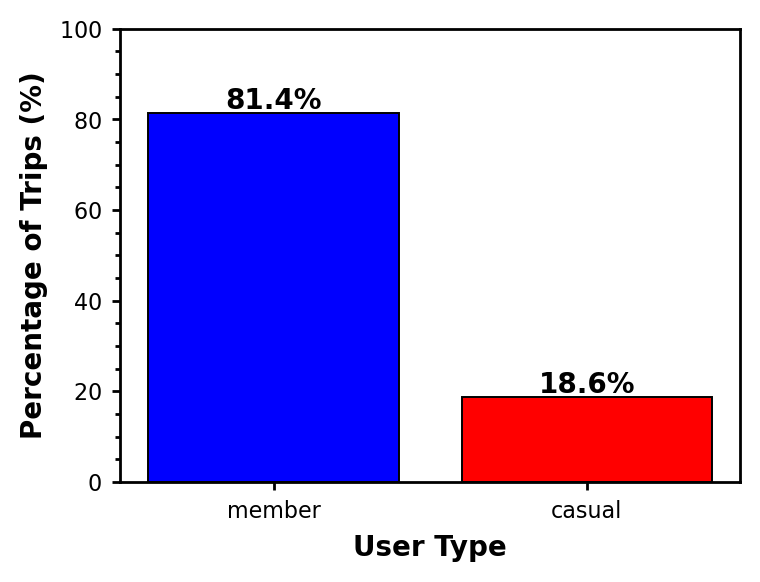

In [47]:
# calculate % of trips by user type; counts are normalized (0,1) and * by 100
trip_counts = df_2023_cleaned['member_casual'].value_counts(normalize=True)*100

# plot bar plots
fig, ax = simple_plot_init([r'User Type', r'Percentage of Trips (%)'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(trip_counts.index, trip_counts.values, color = colors, edgecolor='black', linewidth=0.7)

# add percentage labels on bars
for i, v in enumerate(trip_counts.values):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 100)

plt.show()

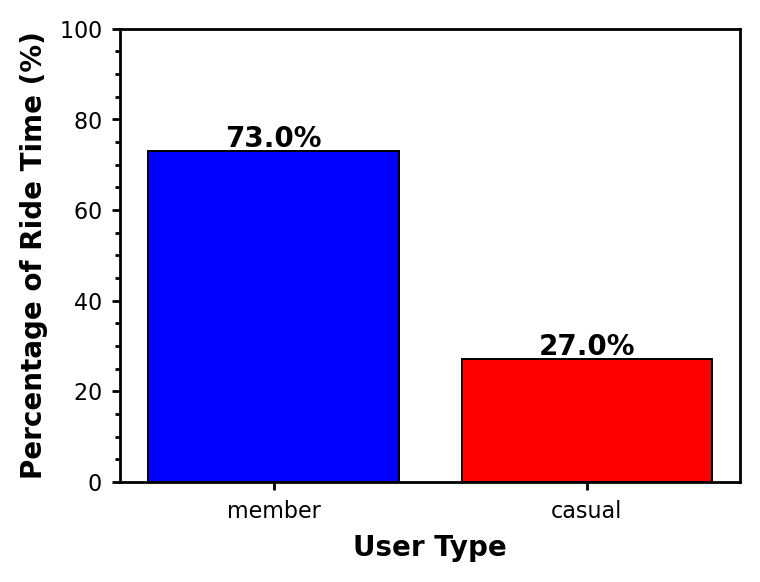

In [48]:
# total duration per user type, group by user and find ride duration
duration_sums = df_2023_cleaned.groupby('member_casual')['ride_duration'].sum()
duration_perct = ((duration_sums / duration_sums.sum())*100).sort_values(ascending=False)

# plot bar plots
fig, ax = simple_plot_init([r'User Type', r'Percentage of Ride Time (%)'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(duration_perct.index, duration_perct.values, color = colors, edgecolor='black', linewidth=0.7)

# add percentage labels on bars
for i, v in enumerate(duration_perct.values):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 100)

plt.show()

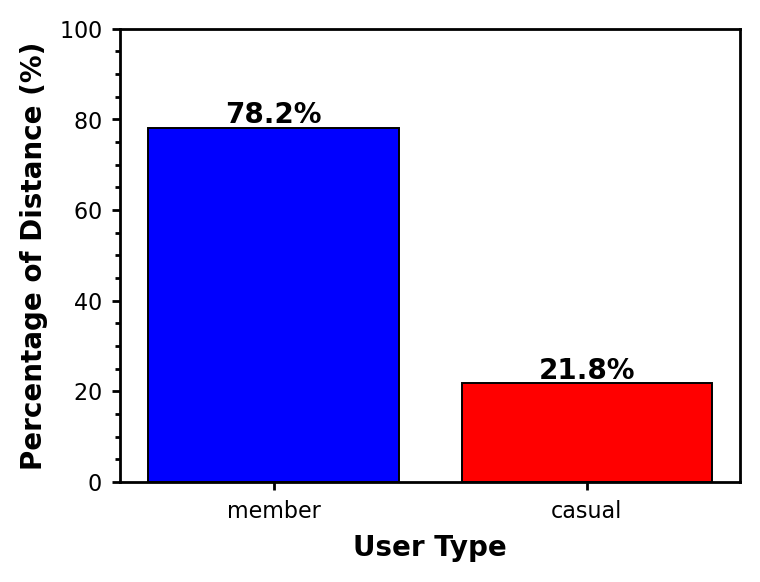

In [49]:
# total distance per user type, group by user and find distance duration
distance_sums = df_2023_cleaned.groupby('member_casual')['ride_distance_km'].sum()
distance_perct = ((distance_sums / distance_sums.sum())*100).sort_values(ascending=False)

# plot bar plots
fig, ax = simple_plot_init([r'User Type', r'Percentage of Distance (%)'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(distance_perct.index, distance_perct.values, color = colors, edgecolor='black', linewidth=0.7)

# add percentage labels on bars
for i, v in enumerate(distance_perct.values):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 100)

plt.show()

#### Types of Bicycles Used

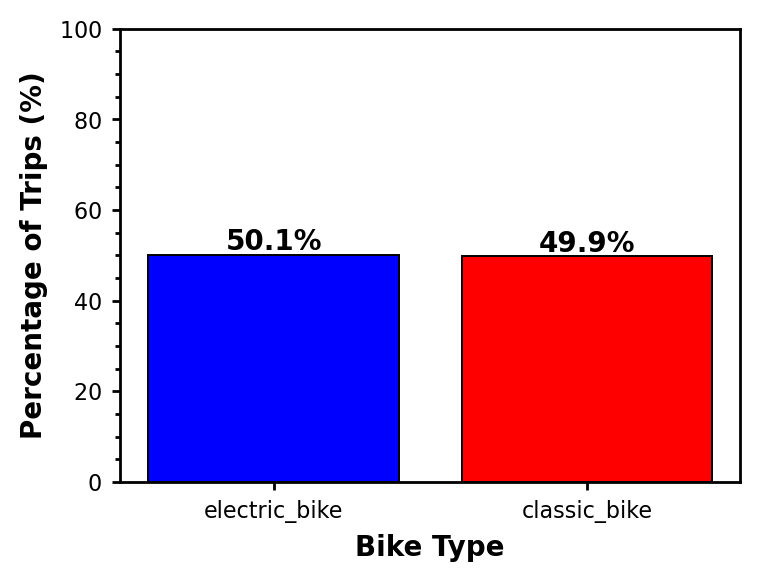

In [50]:
# type of bike used generally

# calculate percentage distribution
bike_type_counts = (df_2023_cleaned['rideable_type'].value_counts(normalize=True)*100).sort_values(ascending=False)

# plot bar plots
fig, ax = simple_plot_init([r'Bike Type', r'Percentage of Trips (%)'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(bike_type_counts.index, bike_type_counts.values, color = colors, edgecolor='black', linewidth=0.7)

# add percentage labels on bars
for i, v in enumerate(bike_type_counts.values):
    ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 100)

plt.show()

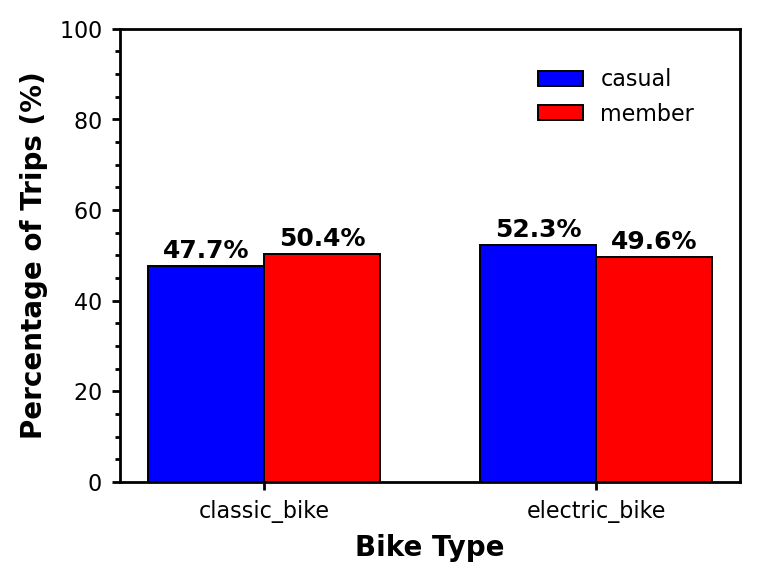

In [51]:
# type of bike used by member

# create grouped count table and convert to percentages within each user type (very important)
# note: the percentages sum to 100% per user type.
grouped = df_2023_cleaned.groupby(['member_casual', 'rideable_type']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby('member_casual')['count'].transform(lambda x: x / x.sum()*100)

# plot bar plots
# pivot the data for plotting
pivot_df = grouped.pivot(index='rideable_type', columns='member_casual', values='percentage').fillna(0)

labels = pivot_df.index.tolist()  # bike types
user_types = pivot_df.columns.tolist()  # member/casual
x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars
color_map = {'casual': 'blue', 'member': 'red'}

fig, ax = simple_plot_init([r'Bike Type', r'Percentage of Trips (%)'], font_size=10, figsize = [4,3], dpi=200)

bars = []
for i, user in enumerate(user_types):
    offset = width * i - width / 2
    bar = ax.bar(x + offset, pivot_df[user], width, label=user, color=color_map[user], edgecolor='black', linewidth=0.7)
    bars.append(bar)

# each bar with the percentage value
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 1),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize = 8, frameon=False, bbox_to_anchor=[0.8, 0.85], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 100)

plt.show()

#### Trip Volume for Day, Hour, Month, Season

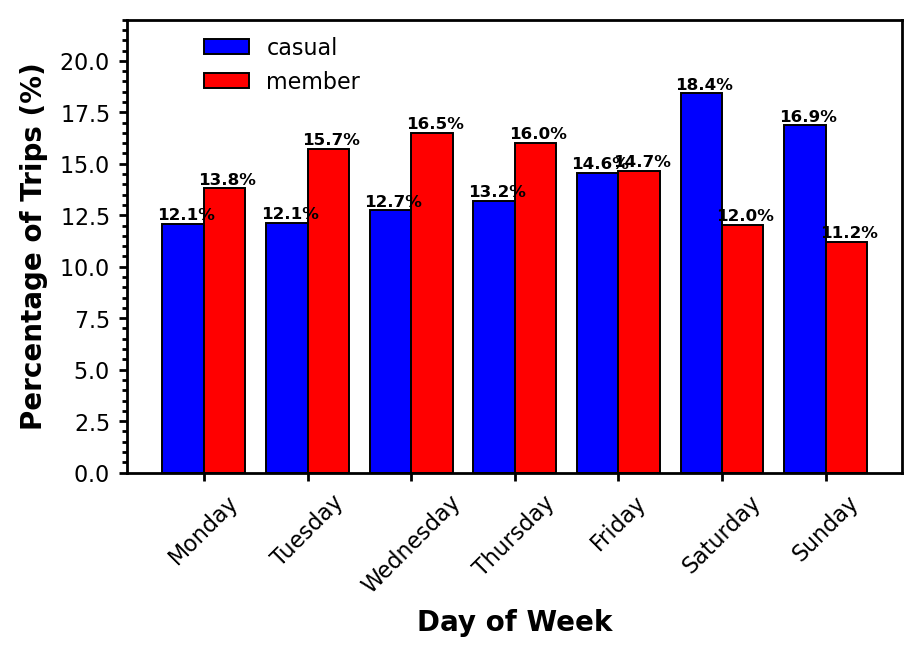

In [52]:
# trip by day of the week

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
grouped = df_2023_cleaned.groupby(['member_casual', 'ride_dayofweek']).size().reset_index(name='count')
grouped['percentage'] = grouped.groupby('member_casual')['count'].transform(lambda x: x / x.sum() * 100)
pivot_df = grouped.pivot(index='ride_dayofweek', columns='member_casual', values='percentage').reindex(day_order)

x = np.arange(len(pivot_df.index))
width = 0.4
color_map = {'casual': 'blue', 'member': 'red'}

fig, ax = simple_plot_init([r'Day of Week', r'Percentage of Trips (%)'], font_size=10, figsize=[5,3], dpi=200)

bars = []
for i, user in enumerate(pivot_df.columns):
    offset = width * i - width / 2
    bar = ax.bar(x + offset, pivot_df[user], width, label=user, color=color_map[user], edgecolor='black', linewidth=0.7)
    bars.append(bar)

# each bar with the percentage value
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', (bar.get_x() + bar.get_width() / 2, height),
                    xytext=(1, 1.5), textcoords="offset points", ha='center', fontsize=6, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=45)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.2, 0.9], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 22)

plt.show()

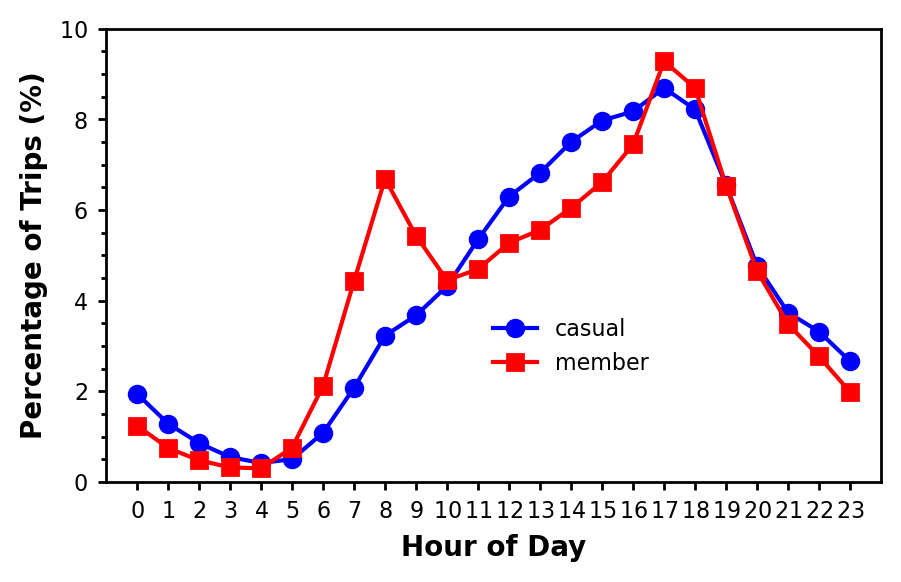

In [53]:
# trip per hour

hour_grouped = df_2023_cleaned.groupby(['ride_hour', 'member_casual']).size().reset_index(name='count')
hour_grouped['percentage'] = hour_grouped.groupby('member_casual')['count'].transform(lambda x: x / x.sum()*100)

fig, ax = simple_plot_init([r'Hour of Day', r'Percentage of Trips (%)'], font_size=10, figsize=[5,3], dpi=200)

color_map = {'casual': 'blue', 'member': 'red'}
marker_map = {'casual': 'o', 'member': 's'}

for user in ['casual', 'member']:
    subset = hour_grouped[hour_grouped['member_casual'] == user]
    ax.plot(subset['ride_hour'], subset['percentage'], label=user, color=color_map[user], marker=marker_map[user])

ax.set_xticks(np.arange(0, 24, 1))
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.6, 0.3], loc='center')
ax.set_ylim(0, 10)
ax.set_xlim(-1, 24)
plt.tick_params(axis='x', which='minor', length=0)
#ax.grid(True, linestyle='--', alpha=0.3)

plt.show()

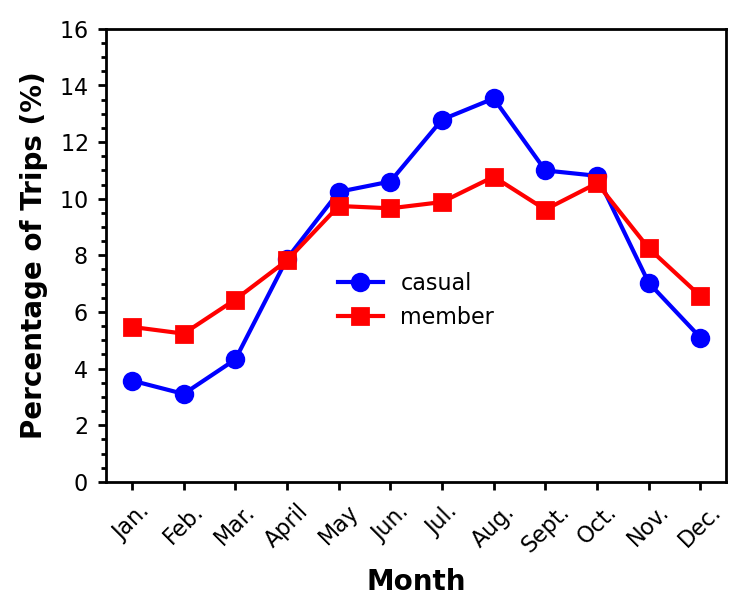

In [54]:
# trip per month

month_grouped = df_2023_cleaned.groupby(['ride_month', 'member_casual']).size().reset_index(name='count')
month_grouped['percentage'] = month_grouped.groupby('member_casual')['count'].transform(lambda x: x / x.sum()*100)

fig, ax = simple_plot_init([r'Month', r'Percentage of Trips (%)'], font_size=10, figsize=[4,3], dpi=200)

color_map = {'casual': 'blue', 'member': 'red'}
marker_map = {'casual': 'o', 'member': 's'}

for user in ['casual', 'member']:
    subset = month_grouped[month_grouped['member_casual'] == user]
    ax.plot(subset['ride_month'], subset['percentage'], label=user, color=color_map[user], marker=marker_map[user])

month_labels = ['Jan.', 'Feb.', 'Mar.', 'April', 'May', 'Jun.', 'Jul.', 'Aug.', 
                'Sept.', 'Oct.', 'Nov.', 'Dec.']

ax.set_xticks(np.arange(1, 13))
ax.set_xticklabels(month_labels, rotation=45)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.5, 0.4], loc='center')
ax.set_ylim(0, 16)
ax.set_xlim(0.5, 12.5)
plt.tick_params(axis='x', which='minor', length=0)
#ax.grid(True, linestyle='-', alpha=1)

plt.show()

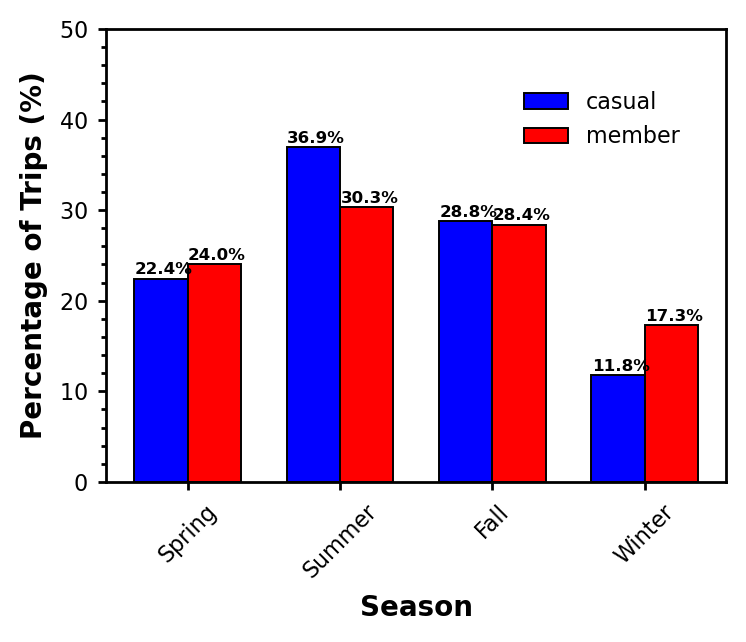

In [55]:
# trip per season

season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_grouped = df_2023_cleaned.groupby(['member_casual', 'ride_season']).size().reset_index(name='count')
season_grouped['percentage'] = season_grouped.groupby('member_casual')['count'].transform(lambda x: x / x.sum() * 100)
pivot_df = season_grouped.pivot(index='ride_season', columns='member_casual', values='percentage').reindex(season_order)

x = np.arange(len(pivot_df.index))
width = 0.35

fig, ax = simple_plot_init([r'Season', r'Percentage of Trips (%)'], font_size=10, figsize=[4,3], dpi=200)

bars = []
for i, user in enumerate(pivot_df.columns):
    offset = width * i - width / 2
    bar = ax.bar(x + offset, pivot_df[user], width, label=user, color=color_map[user], edgecolor='black', linewidth=0.7)
    bars.append(bar)

for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%', (bar.get_x() + bar.get_width() / 2, height),
                    xytext=(1, 1.5), textcoords="offset points", ha='center', fontsize=6, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=45)
ax.legend(frameon=False, fontsize=8, bbox_to_anchor=[0.8, 0.8], loc='center')
plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 50)

plt.show()

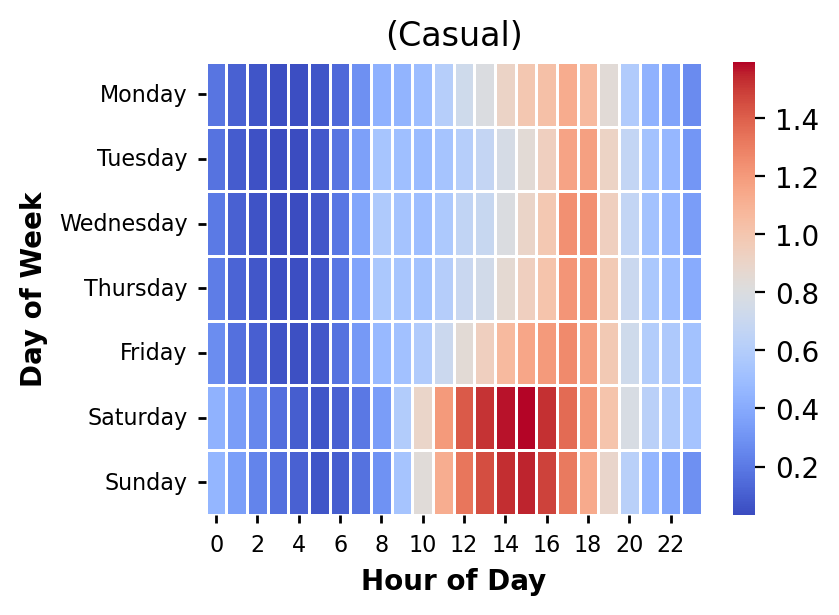

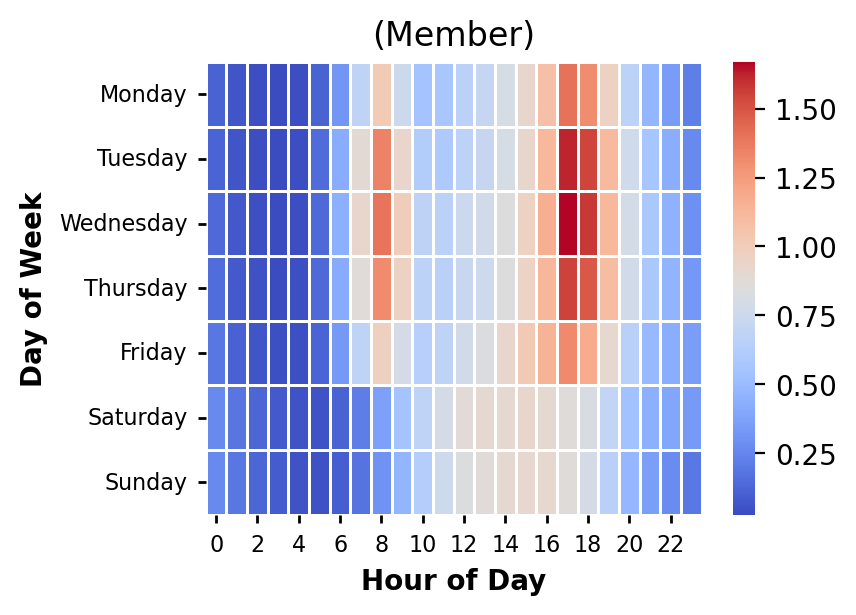

In [56]:
# heatmap for day of week vs time. it gives 2D visualization for time pattern.

heat_data = df_2023_cleaned.groupby(['ride_dayofweek', 'ride_hour', 'member_casual']).size().reset_index(name='count')
heat_data['ride_dayofweek'] = pd.Categorical(heat_data['ride_dayofweek'], categories=day_order, ordered=True)

for user in ['casual', 'member']:
    pivot = heat_data[heat_data['member_casual'] == user].pivot(index='ride_dayofweek', columns='ride_hour', values='count').fillna(0)
    pivot = pivot.div(pivot.sum().sum())*100 # obtain % each
    
    fig, ax = simple_plot_init([r'Hour of Day', r'Day of Week'], font_size=10, figsize=[4,3], dpi=200)
    sns.heatmap(pivot, cmap='coolwarm', linewidths=0.5, linecolor='white')
    plt.title(f'({user.capitalize()})')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.tick_params(axis='x', which='minor', length=0)
    plt.tick_params(axis='y', which='minor', length=0)
    plt.show()

#### Ride Duration and Distance Analysis

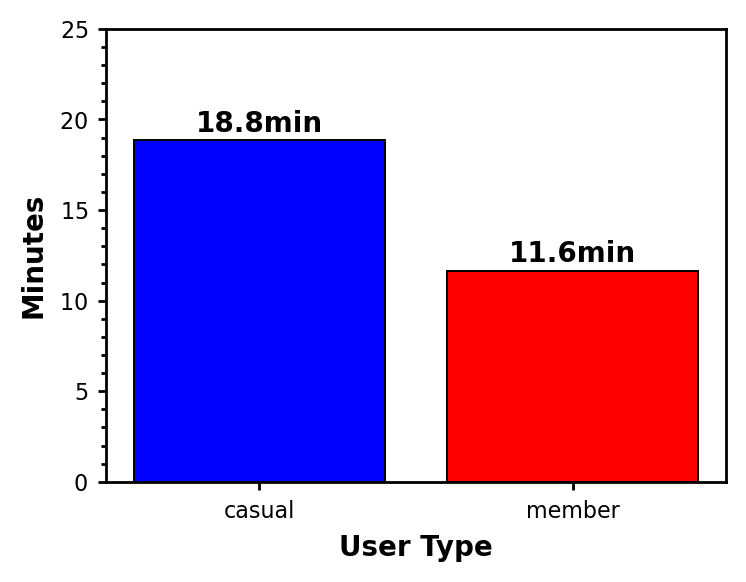

In [57]:
# compute average ride duration
avg_duration = df_2023_cleaned.groupby('member_casual')['ride_duration'].mean().reset_index()

# plot
fig, ax = simple_plot_init([r'User Type', r'Minutes'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(avg_duration['member_casual'], avg_duration['ride_duration'], color = colors, edgecolor='black', linewidth=0.7)

# add labels on bars
for i, v in enumerate(avg_duration['ride_duration']):
    ax.text(i, v + 0.5, f'{v:.1f}min', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 25)

plt.show()

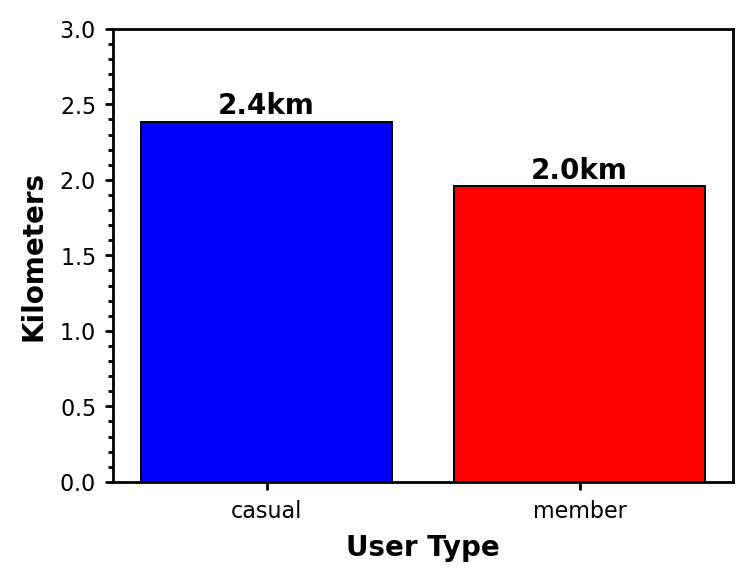

In [58]:
# compute average ride distance
avg_ride_dist = df_2023_cleaned.groupby('member_casual')['ride_distance_km'].mean().reset_index()

# plot
fig, ax = simple_plot_init([r'User Type', r'Kilometers'], font_size=10, figsize = [4,3], dpi=200)

colors = ['blue', 'red']
ax.bar(avg_ride_dist['member_casual'], avg_ride_dist['ride_distance_km'], color = colors, edgecolor='black', linewidth=0.7)

# add labels on bars
for i, v in enumerate(avg_ride_dist['ride_distance_km']):
    ax.text(i, v + 0.05, f'{v:.1f}km', ha='center', fontweight='bold')

plt.tick_params(axis='x', which='minor', length=0)
ax.set_ylim(0, 3)

plt.show()

#### Geographical Analysis

##### Most Popular Start and End Stations

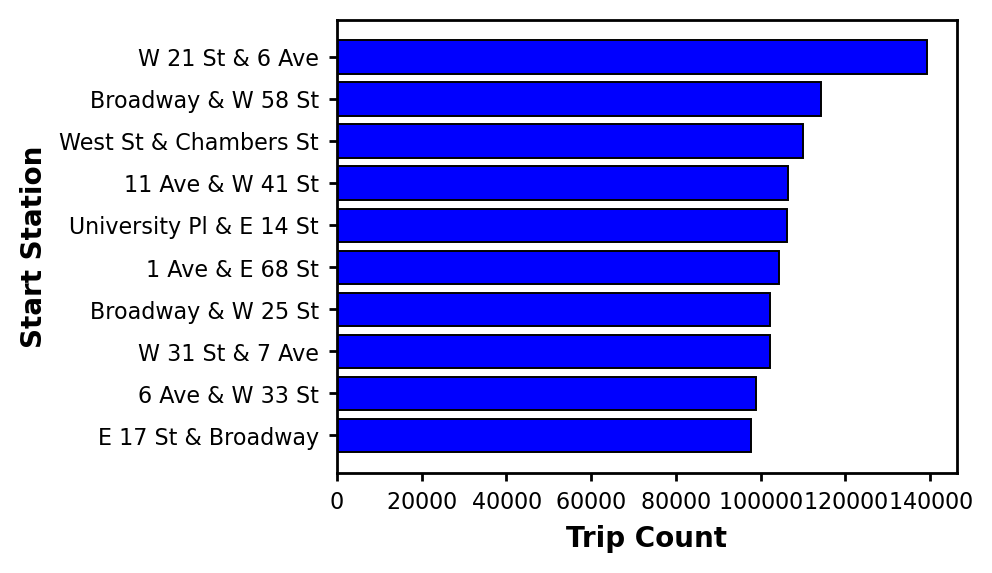

In [59]:
# top 10 general start stations 

top_start = df_2023_cleaned['start_station_name'].value_counts().head(10)

# plot
fig, ax = simple_plot_init([r'Trip Count', r'Start Station'], font_size=10, figsize = [4,3], dpi=200)
ax.barh(top_start.index,top_start.values, color = 'blue', edgecolor='black', linewidth=0.7)
ax.invert_yaxis()

plt.tick_params(axis='x', which='minor', length=0)
plt.tick_params(axis='y', which='minor', length=0)

plt.show()

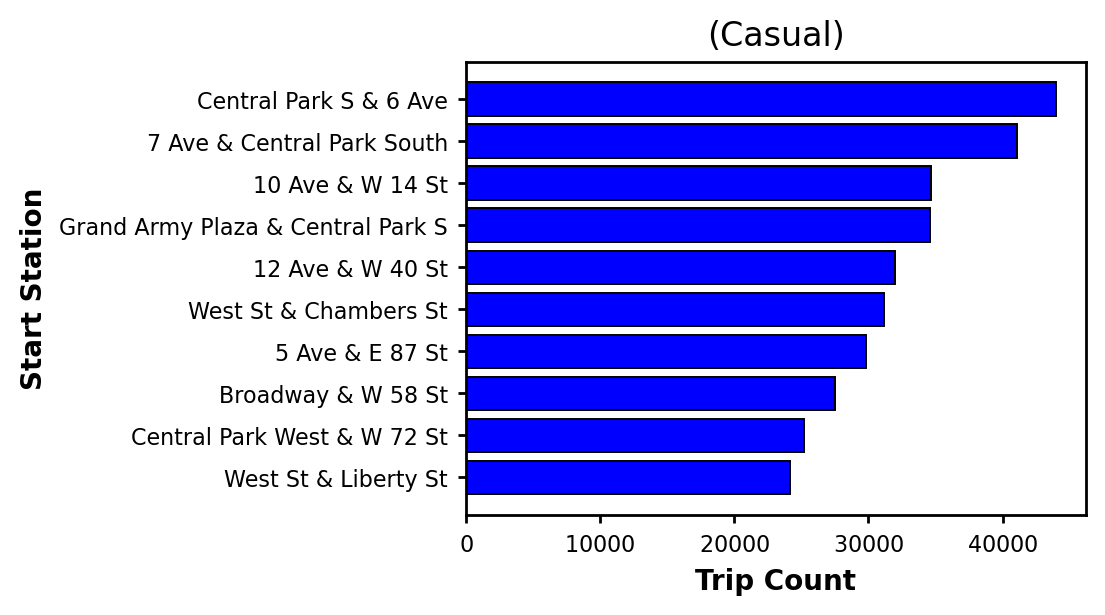

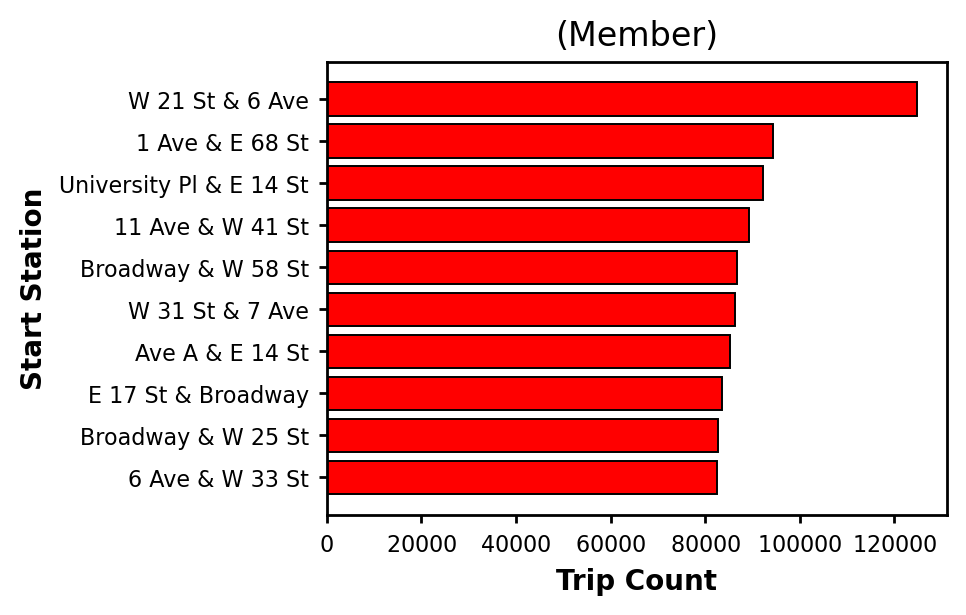

In [60]:
# top 10 start stations my member

for user_type, color in zip(['casual', 'member'], ['blue', 'red']):
    top_start = df_2023_cleaned[df_2023_cleaned['member_casual'] == user_type]['start_station_name'].value_counts().head(10)

    fig, ax = simple_plot_init([r'Trip Count', r'Start Station'], font_size=10, figsize = [4,3], dpi=200)
    ax.barh(top_start.index,top_start.values, color = color, edgecolor='black', linewidth=0.7)
    ax.invert_yaxis()
    plt.tick_params(axis='x', which='minor', length=0)
    plt.tick_params(axis='y', which='minor', length=0)
    ax.set_title(f'({user_type.title()})')
    ax.set_xlabel('Trip Count')
    plt.show()

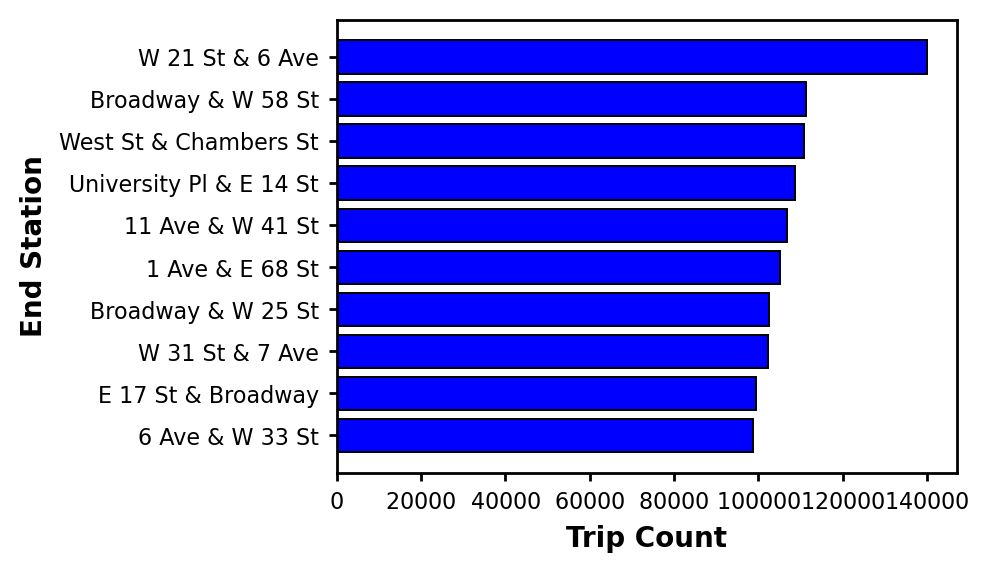

In [61]:
# top 10 general end stations 

top_end = df_2023_cleaned['end_station_name'].value_counts().head(10)

# plot
fig, ax = simple_plot_init([r'Trip Count', r'End Station'], font_size=10, figsize = [4,3], dpi=200)
ax.barh(top_end.index,top_end.values, color = 'blue', edgecolor='black', linewidth=0.7)
ax.invert_yaxis()

plt.tick_params(axis='x', which='minor', length=0)
plt.tick_params(axis='y', which='minor', length=0)

plt.show()

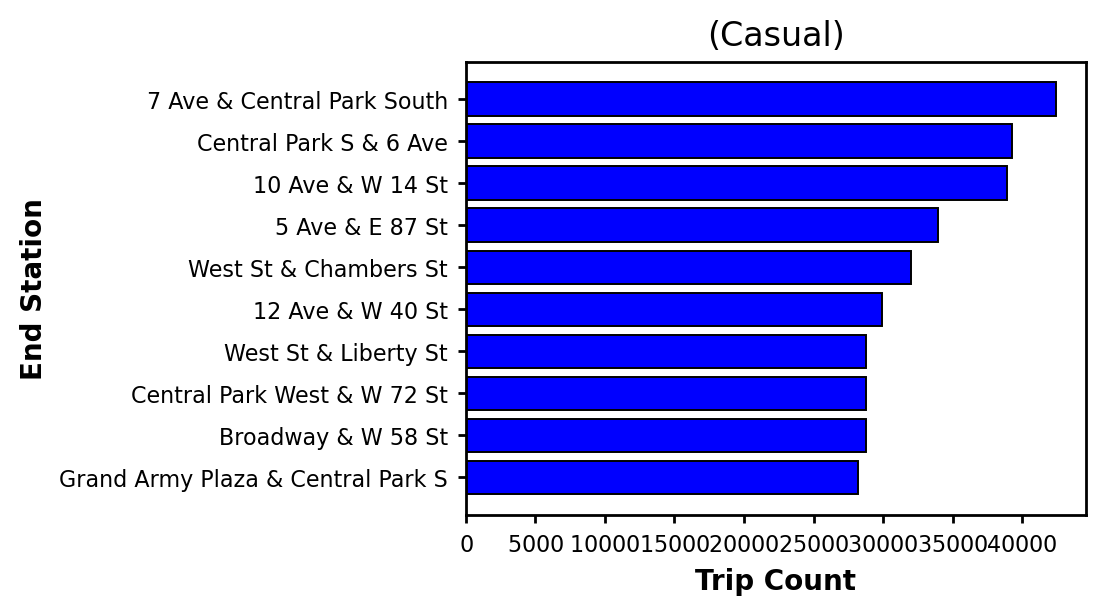

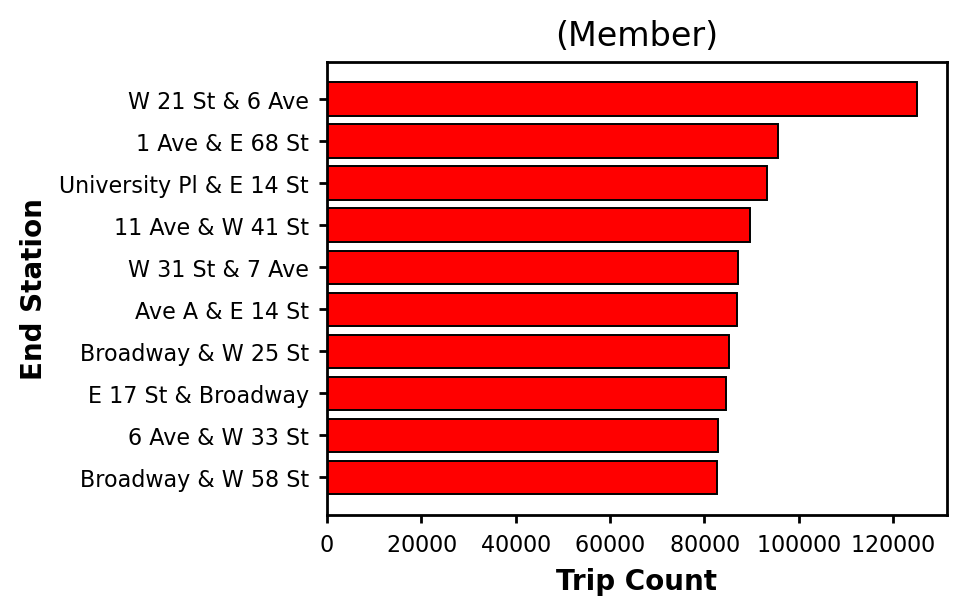

In [62]:
# top 10 end stations my member

for user_type, color in zip(['casual', 'member'], ['blue', 'red']):
    top_start = df_2023_cleaned[df_2023_cleaned['member_casual'] == user_type]['end_station_name'].value_counts().head(10)

    fig, ax = simple_plot_init([r'Trip Count', r'End Station'], font_size=10, figsize = [4,3], dpi=200)
    ax.barh(top_start.index,top_start.values, color = color, edgecolor='black', linewidth=0.7)
    ax.invert_yaxis()
    plt.tick_params(axis='x', which='minor', length=0)
    plt.tick_params(axis='y', which='minor', length=0)
    ax.set_title(f'({user_type.title()})')
    ax.set_xlabel('Trip Count')
    plt.show()

##### Most Common Routes

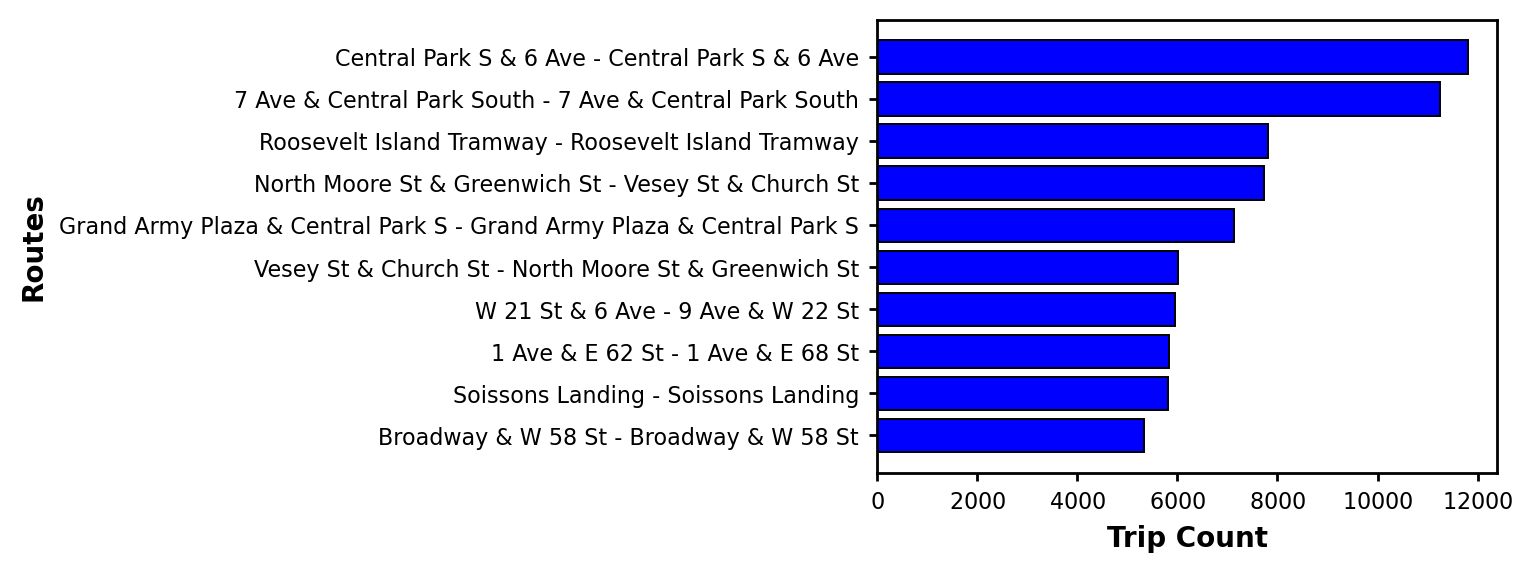

In [8]:
# general 10 most frequent routes

# make a route column
df_2023_cleaned['route'] = df_2023_cleaned['start_station_name'].astype(str) + " - " + df_2023_cleaned['end_station_name'].astype(str)

# top 10 routes
top_routes = df_2023_cleaned['route'].value_counts().head(10)

# plot
fig, ax = simple_plot_init([r'Trip Count', r'Routes'], font_size=10, figsize = [4,3], dpi=200)
ax.barh(top_routes.index,top_routes.values, color = 'blue', edgecolor='black', linewidth=0.7)
ax.invert_yaxis()

plt.tick_params(axis='x', which='minor', length=0)
plt.tick_params(axis='y', which='minor', length=0)

plt.show()

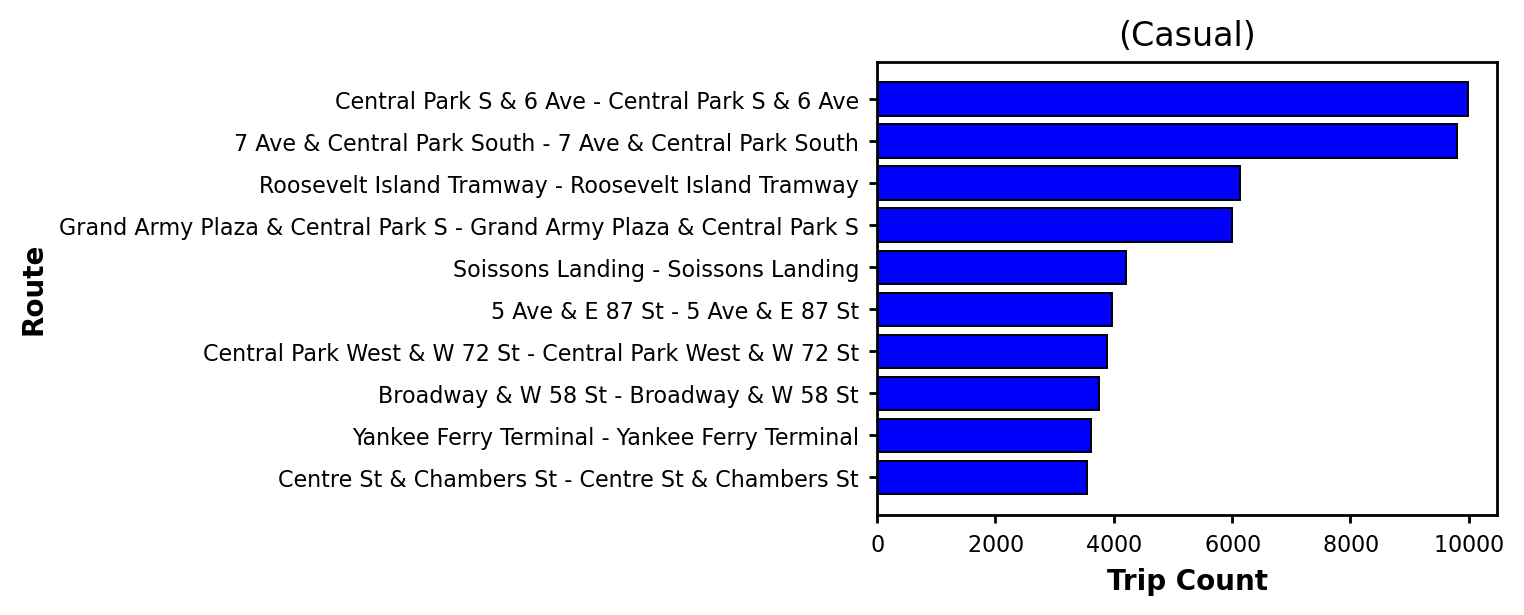

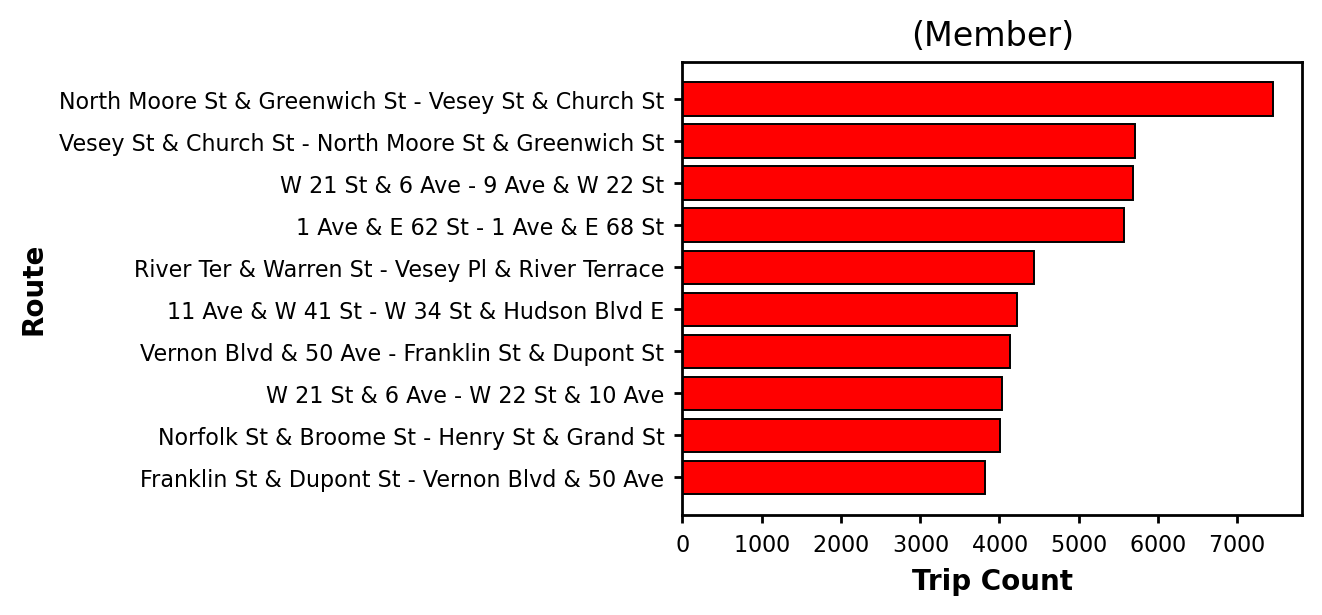

In [9]:
# most frequent routes by member

for user_type, color in zip(['casual', 'member'], ['blue', 'red']):
    top_routes = df_2023_cleaned[df_2023_cleaned['member_casual'] == user_type]['route'].value_counts().head(10)

    fig, ax = simple_plot_init([r'Trip Count', r'Route'], font_size=10, figsize = [4,3], dpi=200)
    ax.barh(top_routes.index,top_routes.values, color = color, edgecolor='black', linewidth=0.7)
    ax.invert_yaxis()
    plt.tick_params(axis='x', which='minor', length=0)
    plt.tick_params(axis='y', which='minor', length=0)
    ax.set_title(f'({user_type.title()})')
    ax.set_xlabel('Trip Count')
    plt.show()

In [62]:
# save file for further analysis

# save citibike cleaned data
df_2023_cleaned.to_csv('citibike_2023_cleaned.csv', index=False)